# Dynamic Tomography using TV-regularization in time domain

Let's assume we aqcuire a tomographic dataset - for simplicity we use parallel beam, and because the approximation is good enough for the synchrotron data we really want to reconstruct. 

We will let $f(x,y,z,t)$ be a function which represents a 3D object changing in time t. The object (or gantry) is rotated continuously in time. Projections are measured along lines parameterized by the angle the object has turned $\theta$ and the radial distance to rotation axis $r$. The projections operator is integration over the lines through the object state at time $t$. Since the object rotates continuously the angle $\theta$ and time $t$ are connected through the relation $\theta = \alpha t$.

Let's denote the projection operator $\mathcal{R}_{\alpha}$

Then we have:

$\mathcal{R}_{\alpha}: \mathbb{R}^3\times\left[0,T\right]\rightarrow\mathbb{R}^2\times S^1$, where $S^1$ denotes the unit circle, is defined by:

$\mathcal{R}_{\alpha}f(r,z,\theta) = \int\int\int f(x,y,z,t)\delta \left(x \cos \theta + y\sin \theta-r\right)\delta(\theta-\alpha t) dx dy dt$

and the adjoint is 

$\mathcal{R}_{\alpha}^{\ast}g(x,y,z,t) = \int\int g(\theta,r,z)\delta \left(x \cos \theta + y\sin \theta-r\right)\delta(\theta-\alpha t) ds d\theta$

We typically solve this problem by assuming the object is static for $180^\circ$ rotation, and then we can solve $\hat{f}=argmin_f\left\{\frac{1}{2}||\mathcal{R}_{\alpha}f-g||_2^2\right\}$

Which can be solved using landweber, cimmino or karzmarc (see week 2 of tomography course) which have in them some regularization.  Or we can use variational methods where the regularization term is more obvious. For example conjugate gradient descent (see week 3, especially variational part 2), with tinkhonov, total variation, sparsity. Easy regularization is truncated SVD, but infeasible for large problems to compute SVD. For Landweber, parameter is k - i.e number of iterations and so on.

In this work we will look at total variation regularization which solves:

$\hat{f}=argmin_f\left\{\frac{1}{2}||\mathcal{R}_{\alpha}f-g||_2^2\right\}+|| |\nabla f| ||_1$

I will use the odl framework to make everything a little easier. 

In [7]:
import sys
sys.path.append("/home/mette/github/odl")
import odl
import scipy.signal
%matplotlib inline
import astra
import numpy as np
import scipy.sparse.linalg
from algorithmImpls import *
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from ImageSliceViewer3D import *
import matplotlib as mpl
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (10, 10)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.filters import try_all_threshold, threshold_mean, threshold_minimum, threshold_otsu
from plot_utils import *
from registration_utils import*

Let's first solve normal static problem as an example using the primal dual hybrid gradient method which we will need later.

We will solve $min f(x) + g(Lx)$
$L$ is an operator between Hilbert spaces $X$ and $Y$
f and g should be f: X -> [0, inf] g: Y-> [0,inf], proper convex and lower semi continous
Convergence gauranteed iff $L$ is linear, $Y$, $X$ finite dimensional and $\sigma$ and $\tau$ satisfy $\tau\cdot\sigma\cdot opnorm(L)^2 < 1$
For classic TV regularization we could want to go $f = |||\nabla x|||_1$, $L = \mathcal{R}$, $g(y) = ||y||^2_2$
But proximal operator of $|||\nabla x|||_1$ does not have closed form expression, so let f(x) = 0, L(x) =(\mathcal{R}(x), \nabla x) since both linear and linear combination of linear operators is linear
then $g=((x1,x2)) = ||x_1||_2^2+||x_2||_1$

Total variation solution basically means: find the reconstruction which is the best tradeoff between  solution being a close fit to the data while preserving edges

We start with 2D example using the one straight from odl

### TV Reconstruction 2D static

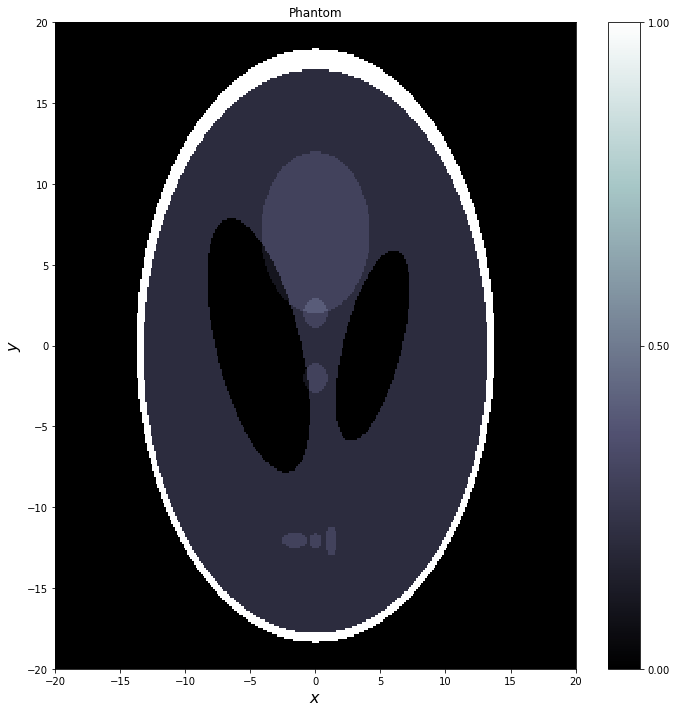

<Figure size 720x720 with 0 Axes>

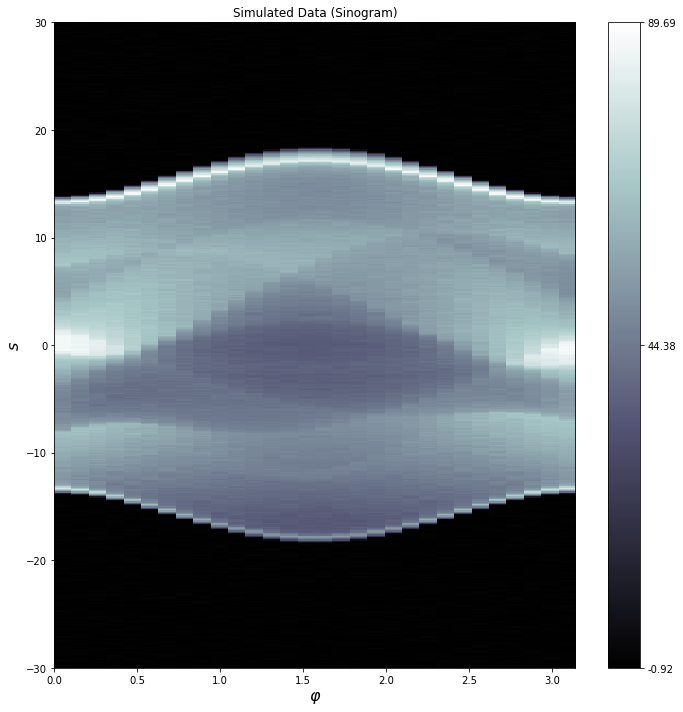

<Figure size 720x720 with 0 Axes>

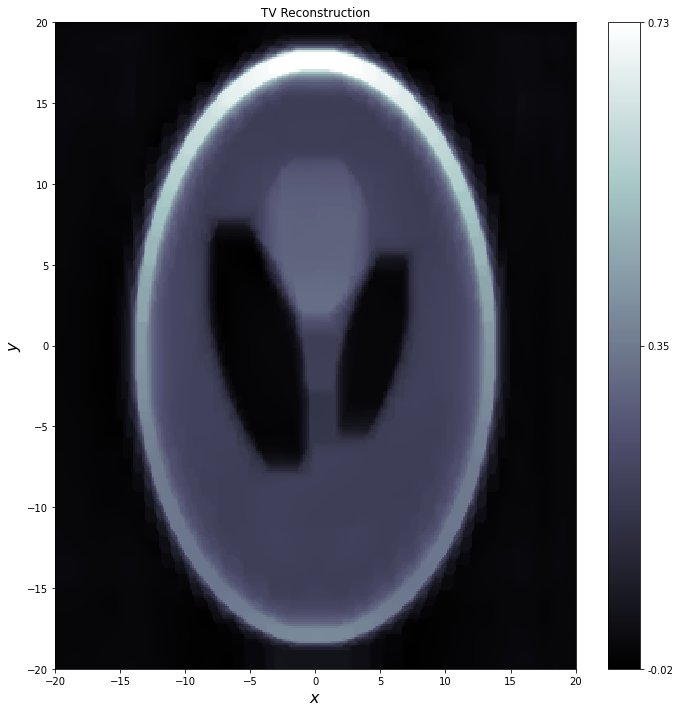

<Figure size 720x720 with 0 Axes>

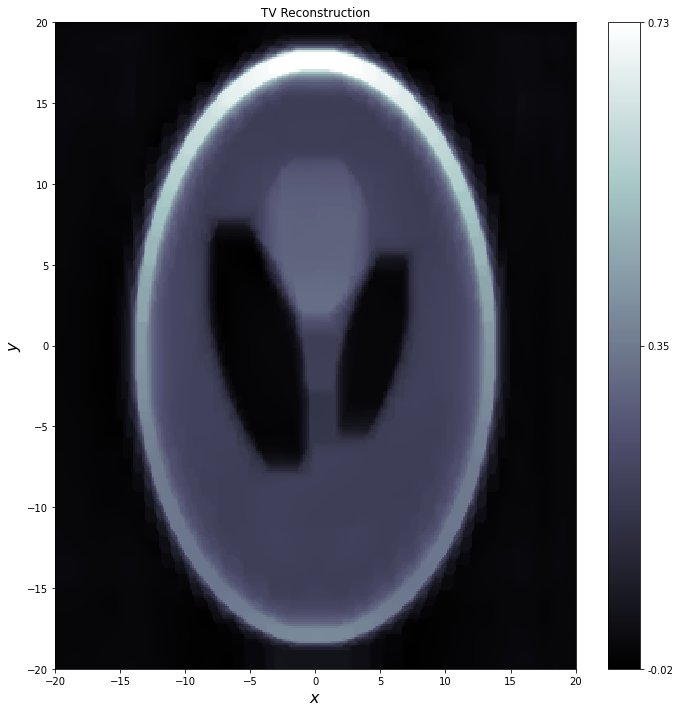

In [8]:
lamda = 0.01#this parameter controls degree of regularization - useless for many angles/little noise, smoother reconstructions for few angles

##VERY IMPORTANT THING HERE IS THAT DETECTOR PARTITION NEEDS TO BE LARGE COMPARED TO ANGLES; OR IT'SFOR SOME REASON NOT PRETTY _ WHY?
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32')

# Make a parallel beam geometry with flat detector
# Angles: uniformly spaced, n = 360, min = 0, max = pi
angle_partition = odl.uniform_partition(0, np.pi, 30)
# Detector: uniformly sampled, n = 512, min = -30, max = 30
detector_partition = odl.uniform_partition(-30, 30, 512)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Create phantom
discr_phantom = odl.phantom.shepp_logan(reco_space, modified=True)

ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

# Create sinogram of forward projected phantom with noise
data = ray_trafo(discr_phantom)
data += odl.phantom.white_noise(ray_trafo.range) * np.mean(data) * 0.01

# Reconstruct
x = TVRecon(data, geometry, reco_space, lamda)

# Display images
discr_phantom.show(title='Phantom')
data.show(title='Simulated Data (Sinogram)')
x.show(title='TV Reconstruction')



In [3]:
reco_space.min_pt

array([-20., -20.])

Now lets try and extend to 2D + time. First define operators - we will simply use diagonal operators, and define a radon operator pr. frame. Several ways to split frames - in N equal partition, non-overlapping or in N* strides overlapping at various degrees. Both will have M angles in each partition - something covering 180 degrees.

### TV 2D + time, phantom data

In [4]:
def load_volume(filepath):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
    height, width = np.load(join(filepath,files[0])).shape
    depth = len(files)
    volume = np.zeros((depth, height, width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = np.load(join(filepath,file))

    volume = volume[:,:,:].astype('float32')
    return volume

In [5]:
volume = load_volume("../PhantomGenerator/output/slow_fast")
volume = volume[:,32:480,32:480].astype('float32')
volume.shape

240it [00:00, 485.30it/s]


(240, 448, 448)

In [ ]:
num_angles = 30#number of angles pr. frame
num_angles_pi = 30 #number of angles for one full rotation

frames = volume.shape[0]-num_angles#210#this is number of frames we want to reconstruct


#We fix some of the rotation here
translation = np.pi/5
thetas_all = np.linspace(0-translation,8*np.pi-translation,240,False) #angles for full acquisition
detector_partition = odl.uniform_partition(-30, 30, 448)
reconstruction_space = odl.uniform_discr(min_pt=[-20, -20, 0], max_pt=[20, 20, 20], shape=[300, 300, frames], dtype='float32')

x, sinogram_spaces = TVReconTime(np.sum(volume[:,:,:], axis=1), reconstruction_space, 0.0001, 0.0, frames, thetas_all, num_angles, num_angles_pi, detector_partition)


In [ ]:
thetas_all.shape

In [ ]:
plt.imshow(sinogram_spaces[1], cmap="gray", aspect="auto")

In [ ]:
frame_offset = int(num_angles/2)
ground_truth = load_volume("../PhantomGenerator/output/slow_fast_no_rotation")[frame_offset:frame_offset+frames,106:406,106:406]
ground_truth_rapid = load_volume("../PhantomGenerator/output/fast_no_rotation")[frame_offset:frame_offset+frames,106:406,106:406]
ground_truth_slow = load_volume("../PhantomGenerator/output/slow_no_rotation")[frame_offset:frame_offset+frames,106:406,106:406]

In [ ]:
#reconstruction comes out flipped
x_flipped = np.flip(x.data, axis=1)

In [ ]:
img = x_flipped[:,:,0]

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
img = ground_truth[0,:,:]

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
from skimage.filters import try_all_threshold, threshold_mean, threshold_yen
threshold_yen(x_flipped)

In [ ]:
thresh_recon = threshold_otsu(x_flipped)
mask_recon = np.zeros_like(x_flipped)
mask_recon[x_flipped > thresh_recon] = 1

thresh = threshold_minimum(ground_truth)
mask_truth = np.zeros_like(ground_truth[:frames,:,:])
mask_truth[ground_truth[:frames,:,:] > thresh] = 1

#also we need to align as groundt truth and reconstruction are not necessarily aligned
#first we estimate warped image based on reconstruction of first frame, which has least movement.
#img = mask_recon[:,:,0].astype(np.uint8)
#reference =  mask_truth[0,:,:].astype(np.uint8)
#warpMat = estimateAffineWarpMatrix(img, reference)

recon_aligned = np.zeros_like(mask_recon)
for f in tqdm(range(mask_recon.shape[-1])):
    img = mask_recon[:,:,f].astype(np.uint8)
    reference =  mask_truth[f,:,:].astype(np.uint8)
    warpMat = estimateAffineWarpMatrix(img, reference)
    mask_recon[:,:,f] = warp_image(mask_recon[:,:,f], warpMat)
    recon_aligned[:,:,f] = warp_image(x_flipped[:,:,f], warpMat)

In [ ]:
ncols = 6
fig, axes = plt.subplots(ncols=ncols, nrows=4, figsize = (15,15))

for i,f in enumerate(range(0,frames,35)):
    ax = axes.ravel()
    ax[i].imshow(recon_aligned[:,:,f], cmap="gray", interpolation='none')
    ax[i].set_title(f'Frame {f}')


for i,f in enumerate(range(0,frames,35)):
    ax = axes.ravel()
    ax[i+ncols].imshow(mask_recon[:,:,f], cmap="gray", interpolation='none')
    ax[i+ncols].set_title(f'Frame {f}')

mask_truth_color = mask_truth.copy()
mask_truth_color[ground_truth_rapid > thresh] = 2
mask_truth_color[ground_truth_slow > thresh] = 3

cmap = mpl.colors.ListedColormap(['black', 'white', 'red', 'green'])

bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i,f in enumerate(range(0,frames,35)):
    ax = axes.ravel()
    ax[i+ncols*2].imshow(mask_truth_color[f,:,:], cmap=cmap, norm = norm)
    ax[i+ncols*2].set_title(f'Frame {f}')

for i, f in enumerate(range(0,frames,35)):
    ax = axes.ravel()
    ax[i+ncols*3].imshow(mask_truth[f,:,:]-mask_recon[:,:,f], cmap="gray")
    ax[i+ncols*3].set_title(f'Frame {f}')

plt.show()

In [ ]:
y_true = mask_truth.astype(np.uint8).ravel()
y_pred = mask_recon.astype(np.uint8).ravel()
cm=confusion_matrix(y_true, y_pred)

In [ ]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Background", "Particle"]
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap="Blues", percent=False)

In [ ]:
from sklearn.metrics import roc_curve, auc # roc curve tools
ground_truth_labels = np.swapaxes(mask_truth, 0, 2).ravel() # we want to make them into vectors
score_value = recon_aligned.ravel() # we want to make them into vectors
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

In [ ]:
#fig, ax = plt.subplots(1,1)

ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic curve')
ax.legend(loc="lower right")

# 

In [ ]:
x_flipped.shape

### TV recon, 2D + time, phantom and compression

In [ ]:
num_angles = 30#number of angles pr. frame
num_angles_pi = 30 #number of angles for one full rotation

frames = volume.shape[0]-num_angles#210#this is number of frames we want to reconstruct


#We fix some of the rotation here
translation = np.pi/5
thetas_all = np.linspace(0-translation,8*np.pi-translation,240,False) #angles for full acquisition
detector_partition = odl.uniform_partition(-30, 30, 448)
reconstruction_space = odl.uniform_discr(min_pt=[-20, -20, 0], max_pt=[20, 20, 20], shape=[300, 300, frames], dtype='float32')

x_comp, sinogram_spaces = TVReconTimeCompression(np.sum(volume[:,:,:], axis=1), reconstruction_space, 0.0001, 0.0, frames, thetas_all, num_angles, num_angles_pi, detector_partition, p=1.2)


In [ ]:
class circle_select():
    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,self.ax = plt.subplots(figsize=(12,12))
        self.ax.imshow(self.im.copy(), cmap="gray", extent=[-self.im.shape[1]/2., self.im.shape[1]/2., -self.im.shape[0]/2., self.im.shape[0]/2. ])
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = ipyw.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        self.circle = []
        self.center = (0.0,0.0)
        self.radius = 0.0

    def circle_from_points(self, points, angular_resolution=50):#x,y,z are complex numbers
        x,y,z = points[:3]
        w = z-x
        w /= y-x
        c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
        r = abs(c+x)
        self.circle = torch.stack([-c.real+r*torch.cos(torch.linspace(0, 2.*math.pi, angular_resolution + 1)[:-1]),-c.imag+r*torch.sin(torch.linspace(0, 2.*math.pi, angular_resolution + 1)[:-1])], axis=1)
        self.center = [-c.real, -c.imag]
        self.radius = r
        
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

    def onclick(self, event):
        self.selected_points.append(complex(event.xdata,event.ydata))
        plt.clf()
        plt.imshow(self.im, cmap="gray", extent=[-self.im.shape[1]/2., self.im.shape[1]/2., -self.im.shape[0]/2., self.im.shape[0]/2. ])
        
        x = [p.real for p in self.selected_points]
        y = [p.imag for p in self.selected_points]

        if len(self.selected_points)>2:
            self.circle_from_points(self.selected_points)
            plt.scatter(self.circle[:,0], self.circle[:,1], color="b")
            self.fig.canvas.mpl_disconnect(self.ka)
        plt.scatter(x,y, color='r')
        plt.draw()
        
class points_select():
    def __init__(self,im1, im2):
        self.im1 = im2
        self.source = None
        self.tagert = None
        self.fig,self.ax = plt.subplots(1,2,figsize=(12,12))
        self.ax[0].imshow(self.im1.copy(), cmap="gray", origin="lower")#, extent=[-self.im1.shape[1]/2., self.im1.shape[1]/2., -self.im1.shape[0]/2., self.im1.shape[0]/2. ])
        self.ax[0].set_title("Source")
        self.ax[1].imshow(self.im1.copy(), cmap="gray", origin="lower")#, extent=[-self.im1.shape[1]/2., self.im1.shape[1]/2., -self.im1.shape[0]/2., self.im1.shape[0]/2. ])
        self.ax[1].set_title("Target")
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = ipyw.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

    def onclick(self, event):
        return
        #self.selected_points.append(complex(event.xdata,event.ydata))
        #plt.clf()
        #plt.imshow(self.im, cmap="gray", extent=[-self.im.shape[1]/2., self.im.shape[1]/2., -self.im.shape[0]/2., self.im.shape[0]/2. ])
        
        #x = [p.real for p in self.selected_points]
        #y = [p.imag for p in self.selected_points]

        #if len(self.selected_points)>2:
         #   self.circle_from_points(self.selected_points)
          #  plt.scatter(self.circle[:,0], self.circle[:,1], color="b")
          #  self.fig.canvas.mpl_disconnect(self.ka)
        #plt.scatter(x,y, color='r')
        #plt.draw()